# Bayesian Linear Regression
Based on the Seoul Bike Sharing Demand dataset located at ../data/SeoulBikeData.csv
Load the data and split into train and test sets, 80% for training and 20% for testing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pymc as pm
import arviz as az

Data Preprocessing, make sure to convert the categorical variables into numeric variables.

In [57]:
file_path = '../data/SeoulBikeData.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
numeric_season = {'Spring' : 1, 'Summer' : 2, 'Autumn' : 3, 'Winter' : 4}
numeric_holiday = {'No Holiday' : 0, 'Holiday' : 1}
numeric_functioning_day = {'No' : 0, 'Yes' : 1}
df['Seasons'] = df['Seasons'].map(numeric_season)
df['Holiday'] = df['Holiday'].map(numeric_holiday)
df['Functioning Day'] = df['Functioning Day'].map(numeric_functioning_day)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['DayOfWeek'] = df['Date'].dt.dayofweek
# df['Month'] = df['Date'].dt.month
# df['Year'] = df['Date'].dt.year
df.drop('Date', axis=1, inplace=True)

print(df.head())
X = df.drop(['Rented Bike Count'], axis=1)
y = df['Rented Bike Count']
print(df.shape)
print(X.shape)
print(y.shape)
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  DayOfWeek  
0

In [58]:
# scale the data
scaler = StandardScaler()
columns_to_scale = X.columns.difference(['Seasons', 'Holiday', 'Functioning Day', 'DayOfWeek'])
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

X_train_np = X_train.to_numpy(dtype=np.float32)
X_test_np = X_test.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (7008, 13)
Test set size: (1752, 13)


#### Bayesian Linear Regression
Use PyMC to perform Bayesian Linear Regression on your new dataset. 

In [59]:
# define the model
# Define the Bayesian model
num_samples = 1000
model = pm.Model()

with model:
    n_features = X_train.shape[1]

    # Weaker priors for beta coefficients
    beta = pm.Normal('beta', mu=0, sigma=1, shape=n_features)

    # Weaker prior for alpha (intercept)
    alpha = pm.Normal('alpha', mu=0, sigma=1)

    # Robust model for sigma
    sigma = pm.HalfCauchy('sigma', beta=1)

    # Expected value (mu) of outcome
    mu = alpha + pm.math.dot(X_train.values, beta)

    # Robust likelihood function (Student's T-distribution)
    nu = pm.Exponential('nu', 1/30)
    Y_obs = pm.StudentT('Y_obs', nu=nu, mu=mu, sigma=sigma, observed=y_train.values)

    # Sample the model
    trace = pm.sample(num_samples, return_inferencedata=True)

# Model summary
summary = az.summary(trace)
print(summary)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


             mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]     1.656   0.963   -0.252    3.387      0.011    0.009    7027.0   
beta[1]     3.112   1.000    1.190    4.885      0.014    0.010    5429.0   
beta[2]    -1.190   1.000   -3.022    0.667      0.013    0.011    6306.0   
beta[3]     0.396   0.967   -1.463    2.139      0.011    0.014    8046.0   
beta[4]     0.990   1.008   -0.901    2.839      0.011    0.011    8402.0   
beta[5]     2.228   0.975    0.513    4.135      0.012    0.009    6494.0   
beta[6]     2.183   0.989    0.332    3.999      0.012    0.010    6654.0   
beta[7]    -0.977   1.009   -2.889    0.900      0.011    0.012    7867.0   
beta[8]    -1.026   0.990   -2.879    0.782      0.012    0.012    6918.0   
beta[9]    15.797   0.998   13.953   17.661      0.013    0.009    5588.0   
beta[10]    0.220   1.021   -1.708    2.117      0.012    0.017    6965.0   
beta[11]    7.431   1.016    5.419    9.294      0.012    0.009    7089.0   

Posterior Predictive Check, plot the posterior predictive distribution of the model

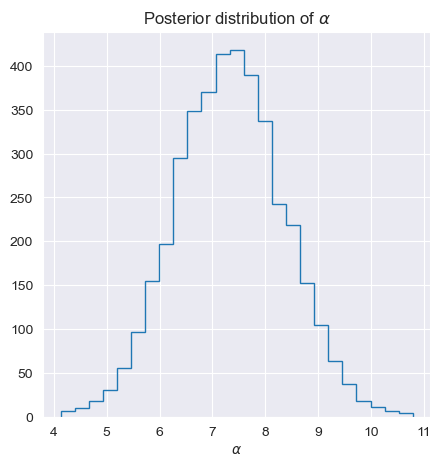

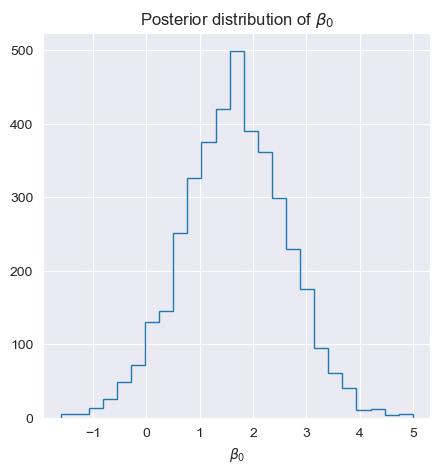

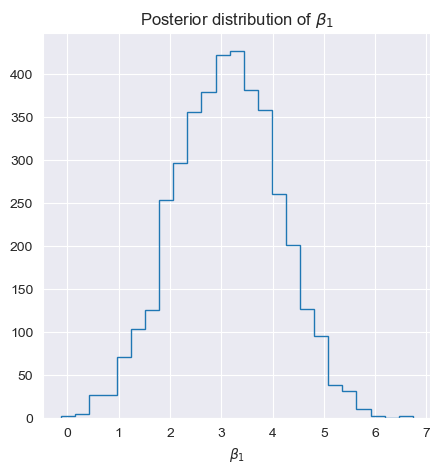

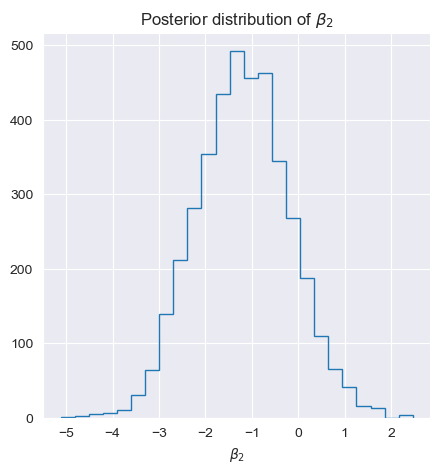

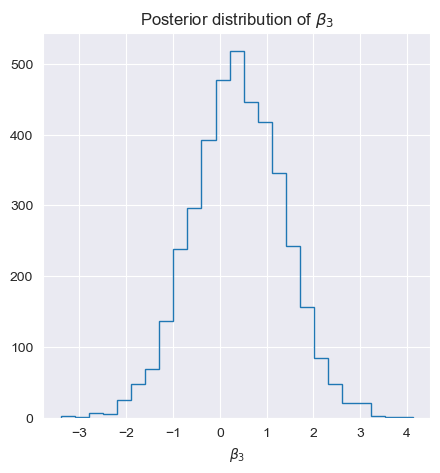

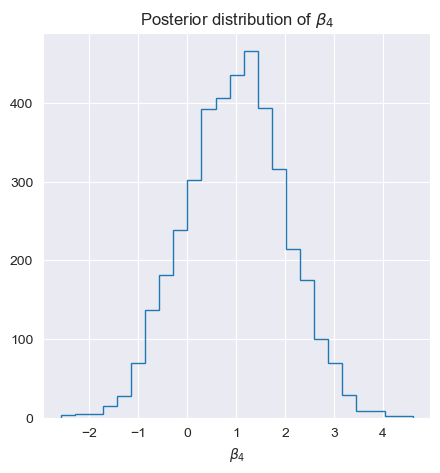

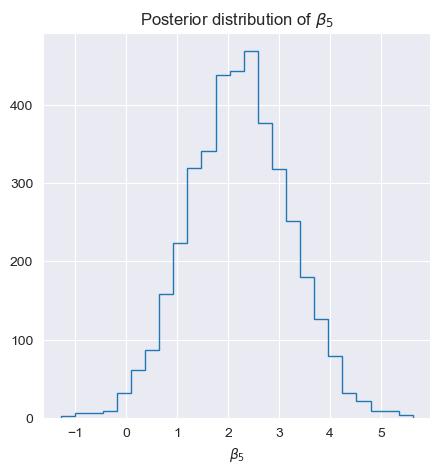

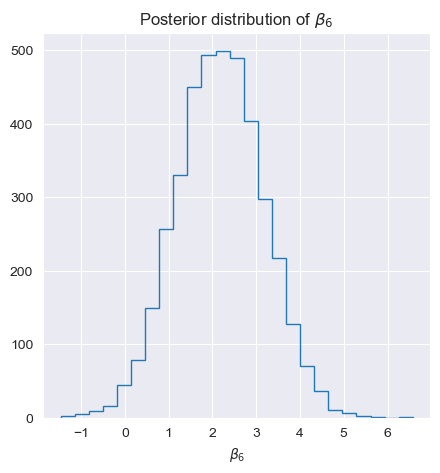

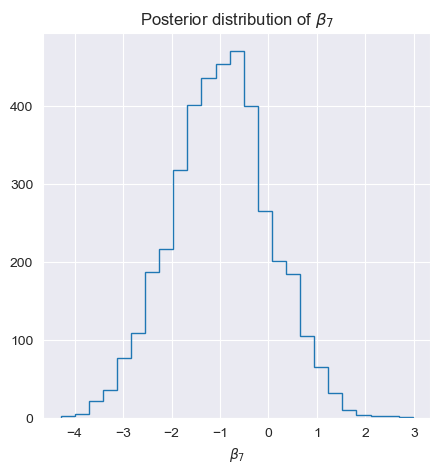

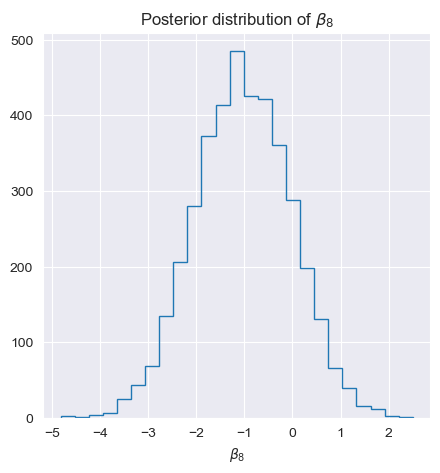

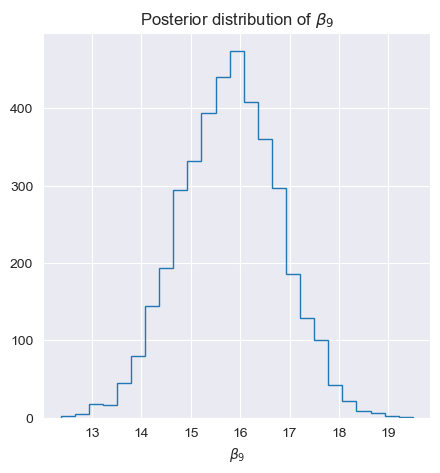

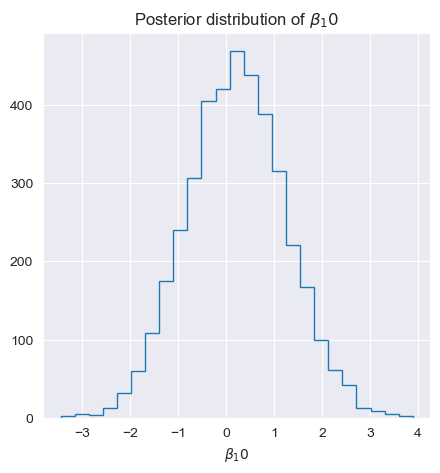

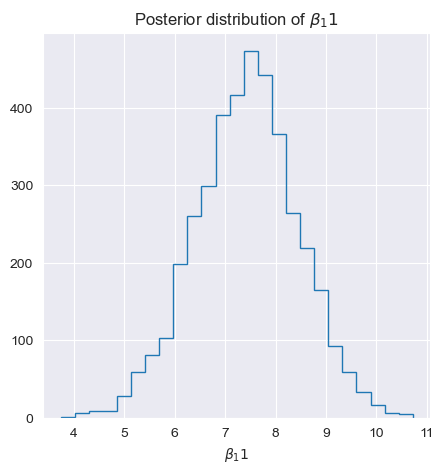

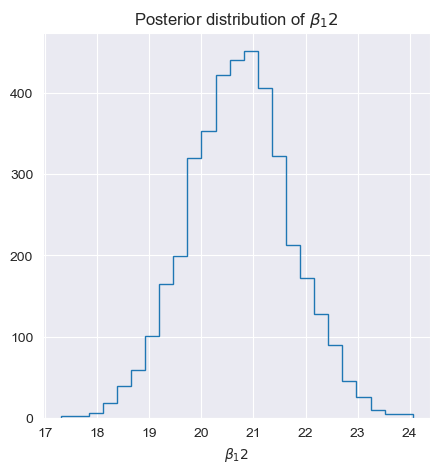

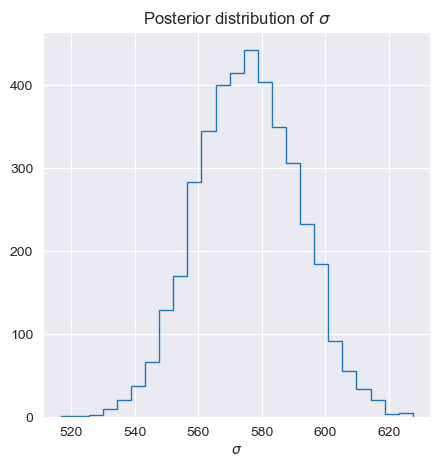

In [60]:
# plot the posterior distributions
plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['alpha'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\alpha$')
plt.title('Posterior distribution of $\\alpha$')
plt.show()

# for 13 betas in the model 
for i in range(trace.posterior['beta'].shape[-1]):
    plt.figure(figsize=(5, 5))
    plt.hist(trace.posterior['beta'].sel(beta_dim_0=i).values.flatten(), bins=25, histtype='step')
    plt.xlabel(f'$\\beta_{i}$')
    plt.title(f'Posterior distribution of $\\beta_{i}$')
    plt.show()


plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['sigma'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\sigma$')
plt.title('Posterior distribution of $\\sigma$')
plt.show()


<Figure size 1000x1000 with 0 Axes>

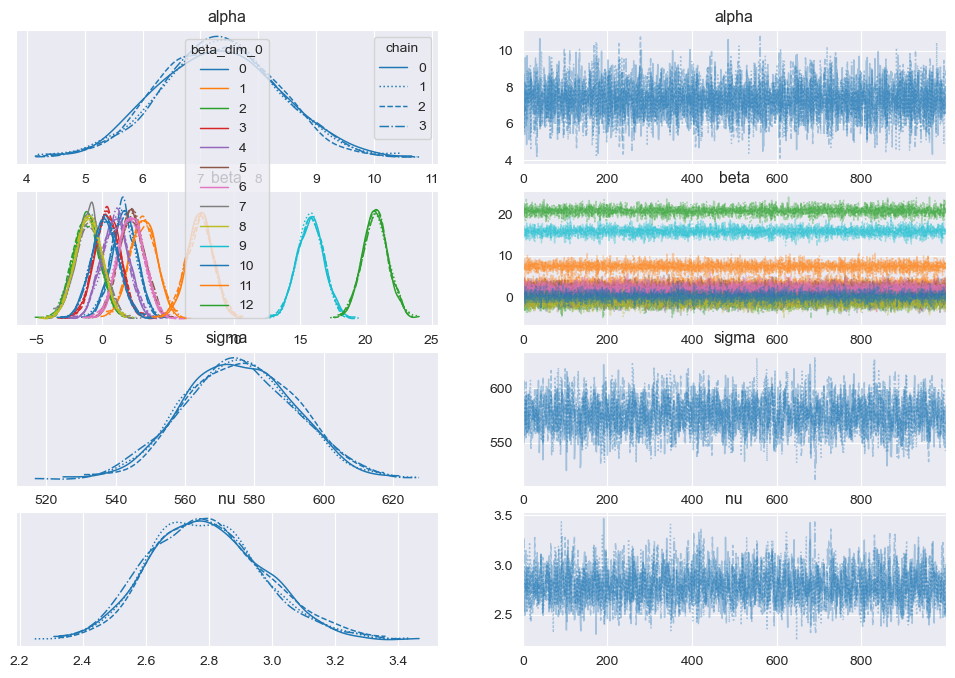

In [62]:
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['alpha', 'beta', 'sigma', 'nu'], legend=True)
plt.show()

Summery posterior mean value for each model parameter generated by arviz.summary

In [63]:
# print the summary of the posterior distribution
summary = az.summary(trace)
print(summary)

             mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]     1.656   0.963   -0.252    3.387      0.011    0.009    7027.0   
beta[1]     3.112   1.000    1.190    4.885      0.014    0.010    5429.0   
beta[2]    -1.190   1.000   -3.022    0.667      0.013    0.011    6306.0   
beta[3]     0.396   0.967   -1.463    2.139      0.011    0.014    8046.0   
beta[4]     0.990   1.008   -0.901    2.839      0.011    0.011    8402.0   
beta[5]     2.228   0.975    0.513    4.135      0.012    0.009    6494.0   
beta[6]     2.183   0.989    0.332    3.999      0.012    0.010    6654.0   
beta[7]    -0.977   1.009   -2.889    0.900      0.011    0.012    7867.0   
beta[8]    -1.026   0.990   -2.879    0.782      0.012    0.012    6918.0   
beta[9]    15.797   0.998   13.953   17.661      0.013    0.009    5588.0   
beta[10]    0.220   1.021   -1.708    2.117      0.012    0.017    6965.0   
beta[11]    7.431   1.016    5.419    9.294      0.012    0.009    7089.0   

Sampling: [Y_obs]


Variable name in posterior_predictive: Y_obs


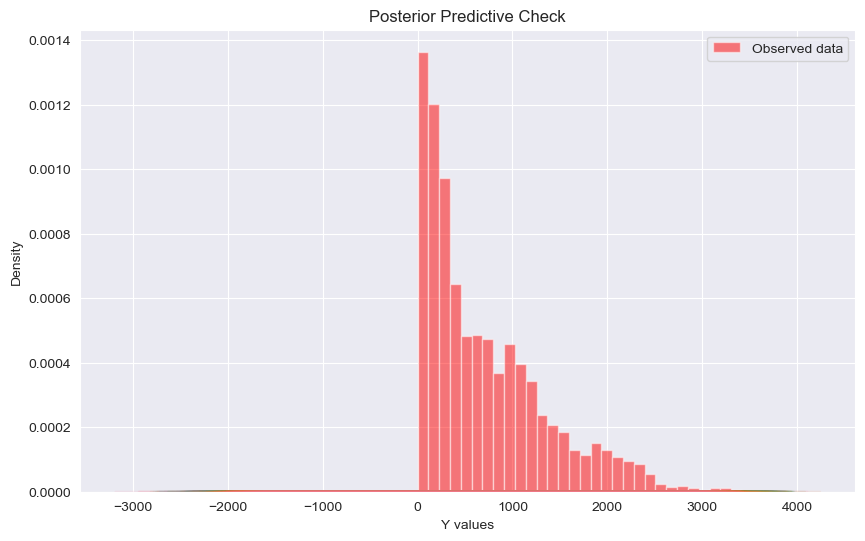

In [44]:

import seaborn as sns

# Assuming your model setup and sampling is correct and stored in 'model' and 'trace'.
num_samples = 1000

with model:
    # Posterior predictive sampling
    ppc = pm.sample_posterior_predictive(trace)

# Accessing the correct group from ppc
posterior_predictive_group = ppc.posterior_predictive

# Get the variable name from the posterior predictive group
var_name = list(posterior_predictive_group.data_vars)[0]
print("Variable name in posterior_predictive:", var_name)

# Extracting the predictive samples
predicted_data = posterior_predictive_group[var_name].values

# Visualization
plt.figure(figsize=(10, 6))

# Plotting observed data histogram
plt.hist(y_train, bins=30, density=True, alpha=0.5, label='Observed data', color='red')

# Plotting KDE for each sampled prediction
for i in range(predicted_data.shape[0]):
    sns.kdeplot(predicted_data[i, :], color='blue', alpha=0.1)

plt.title('Posterior Predictive Check')
plt.xlabel('Y values')
plt.ylabel('Density')
plt.legend()
plt.show()


In [64]:
y_pred = []
with model:
    y_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [Y_obs]


<Axes: xlabel='Y_obs / Y_obs'>

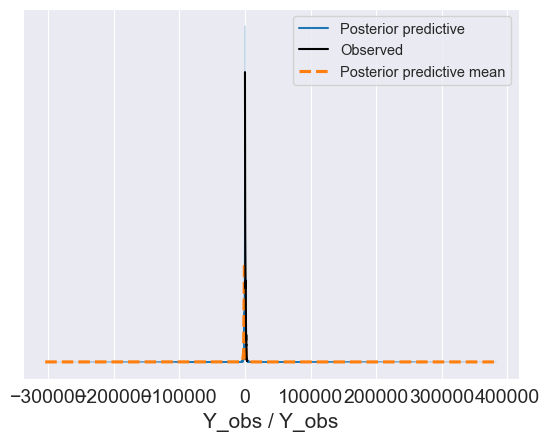

In [65]:
# plot ppd
az.plot_ppc(y_pred)